# Black-Scholes solution

The value of a European call option is:

$$
C(S_t,t) = N(d_1(t,S(t)))S_t -Ke^{r(T-t)}N(d_2(t,S(t))) \\
d_1 = \frac{1}{\sigma\sqrt{T-t}}(log\frac{S(t)}{K}+(r+\frac{1}{2}\sigma^2)(T-t)) \\
d_2 = d_1-\sigma\sqrt{T-t} \\
$$

Under the NA0 (No Arbitrage Opportunity) the assumption the **put-call parity** exists as:

$$
C(S_t,t) - P(S_t,t) = S_t -Ke^{r(T-t)}\\
$$

The value of a European put option is:

$$
P(S_t,t) =  N(-d_2)PV(K) - N(-d_1)S_t
$$

$N(.)$ is the cumulative distribution function of the standard normal distribution <br>
$K$ is the strike price <br>
$T-t$ is the time to maturity (expressed in years)<br>
$S_t$ is the spot price of the underlying asset<br>
$r$ is the risk-free rate (annual rate, expressed in terms of continuous compounding)<br>
$\sigma$ is the implied volatility of returns of the underlying asset.<br>


In [1]:
from typing import Literal
import numpy as np
import scipy.stats as stats

from modules.pricings import (
    black_scholes_option_price,
    from_call_to_put,
    from_put_to_call,
)

In [2]:
call_price = black_scholes_option_price(100, 110, 0.05, 1, 0.2, "call")

print(f"Call price: $ {call_price:.2f}")

put_price = black_scholes_option_price(100, 110, 0.05, 1, 0.2, "put")
print(f"Put price using the BS formula: $ {put_price:.2f}")
print(
    f"Put price using the put call parity formula: $ {from_call_to_put(call_price,100,110,0.05,1):.2f}"
)

Call price: $ 6.04
Put price using the BS formula: $ 10.68
Put price using the put call parity formula: $ 10.68


# Monte Carlo simulation

Given the current asset price at time $0$ is $S_0$, then the asset price at time $T$ can be expressed as:

$$
S_T = S_0e^{(r- \frac{\sigma^2}{2})T  + \sigma W_T}
$$

$T$ is the time to maturity<br>
$S_t$ is the spot price of the underlying asset<br>
$r$ is the risk-free rate (annual rate, expressed in terms of continuous compounding)<br>
$\sigma$ is the volatility of returns of the underlying asset.<br>
$W_T$ is the Brownian motion.<br>

Where $W_T$ follows the normal distribution with mean $0$ and variance $T$. The pay-off of the call option is $max(S_T−K,0)$ and for the put option is $max(K−ST)$.


In [4]:
from modules.pricings import monte_carlo_option_price


In [5]:
call_price, call_price_std_error = monte_carlo_option_price(
    s0=100, k=110, r=0.05, tau=1, sigma=0.2, nb_simulation=100000, option_type="call"
)
print(f"Call price: $ {call_price:.2f} +/- {call_price_std_error:.2f}")
put_price, put_price_std_error = monte_carlo_option_price(
    s0=100, k=110, r=0.05, tau=1, sigma=0.2, nb_simulation=100000, option_type="put"
)
print(f"Put price: $ {put_price:.2f} +/- {put_price:.2f}")

Call price: $ 6.03 +/- 0.04
Put price: $ 6.05 +/- 6.05


# Comparing Black-Scholes formula to Monte-Carlo simulation

## Call options


In [6]:
bs_call_price = black_scholes_option_price(100, 110, 0.05, 1, 0.2, "call")
mc_call_price, mc_call_price_std = monte_carlo_option_price(
    100, 110, 0.05, 1, 0.2, 1000, "call"
)

print(f"Black-Scholes call price: $ {bs_call_price:.2f}")
print(f"Monte-Carlo call price: $ {mc_call_price:.2f} +/- {mc_call_price_std:.2f}")

Black-Scholes call price: $ 6.04
Monte-Carlo call price: $ 5.72 +/- 0.35


## Put options


In [7]:
bs_put_price = black_scholes_option_price(100, 110, 0.05, 1, 0.2, "put")
mc_put_price, mc_put_price_std = monte_carlo_option_price(
    100, 110, 0.05, 1, 0.2, 100000, "put"
)

print(f"Black-Scholes put price: $ {bs_put_price:.2f}")
print(f"Monte-Carlo put price: $ {mc_put_price:.2f} +/- {mc_put_price_std:.2f}")

Black-Scholes put price: $ 10.68
Monte-Carlo put price: $ 5.96 +/- 0.04


# Using Tensorflow Quanrt


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

tf.compat.v1.enable_eager_execution()
import tf_quant_finance as tff

option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol

In [4]:
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
    volatilities=volatilities,
    strikes=strikes,
    expiries=expiries,
    forwards=forwards,
    discount_factors=discount_factors,
    is_call_options=is_call_options,
)
prices

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.14798729, 0.24216815, 0.74814549, 0.02260333])>

In [5]:
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
    volatilities=volatilities,
    strikes=strikes,
    expiries=expiries,
    forwards=forwards,
    discount_factors=discount_factors,
    is_call_options=is_call_options,
)
prices

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.14798729, 0.24216815, 0.74814549, 0.02260333])>

In [6]:
# Initial positions for finding implied vol.
initial_volatilities = np.array([2.0, 0.5, 2.0, 0.5])
# Identifier whether the option is call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# Find the implied vols beginning at initial_volatilities.
implied_vols = implied_vol(
    prices=prices,
    strikes=strikes,
    expiries=expiries,
    forwards=forwards,
    discount_factors=discount_factors,
    is_call_options=is_call_options,
    initial_volatilities=initial_volatilities,
    validate_args=True,
    tolerance=1e-9,
    max_iterations=200,
    name=None,
    dtype=None,
)
implied_vols

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.7, 1.1, 2. , 0.5])>

# Stock Options Evaluation : pt 1


In [1]:
###PACKAGES AND FORMATTING

# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy
from yahoo_fin.stock_info import *
from yahoo_fin.options import *
import math
from datetime import date
from datetime import datetime

from modules.stock_symbols import get_largest_symbols_by_country_normal

In [3]:
# Generating S&P 500 List of Stocks
sp_list = get_largest_symbols_by_country_normal(100)

sp_list = sp_list[:5]

['AAPL',
 'MSFT',
 'GOOG',
 'AMZN',
 'BRK-B',
 'NVDA',
 'TSLA',
 'META',
 'JNJ',
 'UNH',
 'V',
 'XOM',
 'WMT',
 'JPM',
 'PG',
 'LLY',
 'MA',
 'CVX',
 'HD',
 'MRK',
 'ABBV',
 'KO',
 'AVGO',
 'ORCL',
 'PEP',
 'PFE',
 'BAC',
 'TMO',
 'COST',
 'CSCO',
 'MCD',
 'CRM',
 'NKE',
 'DIS',
 'TMUS',
 'ABT',
 'DHR',
 'ADBE',
 'VZ',
 'TXN',
 'UPS',
 'CMCSA',
 'NEE',
 'NFLX',
 'AMD',
 'PM',
 'BMY',
 'RTX',
 'MS',
 'WFC',
 'T',
 'INTC',
 'QCOM',
 'AMGN',
 'COP',
 'BA',
 'HON',
 'INTU',
 'LMT',
 'UNP',
 'AXP',
 'LOW',
 'SBUX',
 'IBM',
 'PLD',
 'ELV',
 'SPGI',
 'DE',
 'SYK',
 'CAT',
 'GS',
 'GILD',
 'GE',
 'AMAT',
 'CVS',
 'BKNG',
 'BLK',
 'MDLZ',
 'NOW',
 'AMT',
 'ADI',
 'SCHW',
 'TJX',
 'REGN',
 'ISRG',
 'ADP',
 'C',
 'PGR',
 'EL',
 'PYPL',
 'MMC',
 'VRTX',
 'MO',
 'CI',
 'SO',
 'ZTS',
 'DUK',
 'TGT',
 'HCA',
 'BDX']

In [12]:
# Creating options dataset

sp_list = sp_list[:5]

options_df = pd.DataFrame()
expiration = get_expiration_dates(sp_list[0])[1]
for stock in sp_list:
    try:
        price = get_live_price(stock)  # current market price of the stock
        option = get_calls(stock, expiration)
        option["CurrentPrice"] = price
        option["Ticker"] = stock
        option["DateExp"] = expiration
        options_df = pd.concat([options_df,option],)
        print(price)
        print(stock)
    except:
        print("Option contract not available on " + str(expiration))
        pass

164.66000366210938
AAPL
291.6000061035156
MSFT
108.9000015258789
GOOG
102.05999755859375
AMZN
312.510009765625
BRK-B


In [13]:
options_df = options_df[
    [
        "Contract Name",
        "Strike",
        "Bid",
        "Ask",
        "CurrentPrice",
        "Volume",
        "Open Interest",
        "Ticker",
        "DateExp",
    ]
]

options_df = options_df[options_df.Bid != "-"]
options_df = options_df[options_df.Ask != "-"]

options_df["AvgPrice"] = (
    pd.to_numeric(options_df.Bid) + pd.to_numeric(options_df.Ask)
) / 2
options_df["OptionCost"] = options_df["AvgPrice"] * 100
options_df["BE_percent"] = (
    (options_df.Strike + options_df.AvgPrice) / (options_df.CurrentPrice)
) - 1

options_df

,Contract Name,Strike,Bid,Ask,CurrentPrice,Volume,Open Interest,Ticker,DateExp,AvgPrice,OptionCost,BE_percent
0,AAPL230421C00050000,50.0,114.15,115.25,164.660004,7,1173,AAPL,"April 21, 2023",114.700,11470.0,0.000243
1,AAPL230421C00060000,60.0,104.15,105.30,164.660004,10,187,AAPL,"April 21, 2023",104.725,10472.5,0.000395
2,AAPL230421C00065000,65.0,99.20,100.30,164.660004,2,115,AAPL,"April 21, 2023",99.750,9975.0,0.000547
3,AAPL230421C00070000,70.0,94.20,95.30,164.660004,2,217,AAPL,"April 21, 2023",94.750,9475.0,0.000547
4,AAPL230421C00075000,75.0,89.25,90.30,164.660004,1,118,AAPL,"April 21, 2023",89.775,8977.5,0.000698
...,...,...,...,...,...,...,...,...,...,...,...,...
37,BRKB230421C00395000,395.0,0.00,0.36,312.510010,-,1,BRK-B,"April 21, 2023",0.180,18.0,0.264535
38,BRKB230421C00400000,400.0,0.00,1.01,312.510010,2,2,BRK-B,"April 21, 2023",0.505,50.5,0.281575
39,BRKB230421C00430000,430.0,0.00,4.80,312.510010,-,1,BRK-B,"April 21, 2023",2.400,240.0,0.383636
40,BRKB230421C00440000,440.0,0.00,4.80,312.510010,-,1,BRK-B,"April 21, 2023",2.400,240.0,0.415635


0.0005465585806454509

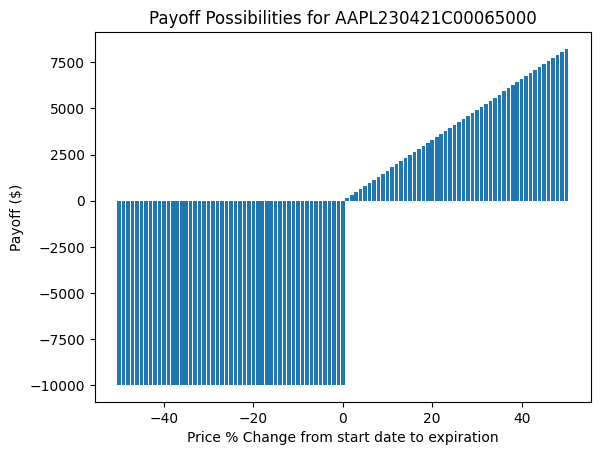

In [14]:
def price_percent_payoff(x, row):  # x is in decimal format
    new_price = row.CurrentPrice * (1 + x)
    if (100 * new_price - 100 * row.Strike - row.OptionCost) >= 0:
        payoff = 100 * new_price - 100 * row.Strike - row.OptionCost
    else:
        payoff = -(row.OptionCost)
    return payoff


ind = 2
ticker = "AAPL"
x_axis = np.arange(-50, 51, 1)
payoffs = []
for p in range(len(x_axis)):
    percent = (p - 50) * 0.01
    payoff = price_percent_payoff(
        percent, options_df[options_df.Ticker == ticker].iloc[ind]
    )
    payoffs.append(payoff)

contract = options_df[options_df.Ticker == ticker].iloc[ind]["Contract Name"]
plt.bar(x_axis, payoffs)
plt.xlabel("Price % Change from start date to expiration")
plt.ylabel("Payoff ($)")
plt.title("Payoff Possibilities for " + str(contract))
# plt.savefig('T_prices.png', dpi = 800)

options_df[options_df.Ticker == ticker].iloc[ind]["BE_percent"]

# Stock Options Evaluation : pt 2


In [15]:
def delta_dist(ticker, duration, sample_size):
    stock = get_data(ticker).close
    dates = list(stock.index)
    duration = int(duration)
    sample_size = int(sample_size)
    deltas = []

    for s in range(sample_size):
        try:
            x = random.randint(0, (sample_size - 1))
            start = stock[x]
            stop = stock[x + duration]
            difference_percent = (stop - start)/start
            deltas.append(difference_percent)
        except:
            pass

    return deltas


In [16]:
def binned(diffs):
    bins = []
    for bin in range(101):    #needs to be 101 to count -50% and +50%
        begin = (bin - 50)*0.01
        def between_bins(k):
            return (k <= begin + .01) and (k > begin)
        count = list(filter(between_bins, diffs))
        amount = len(count)/len(diffs)  #amount is percent of total
        bins.append(amount)
    return(bins)

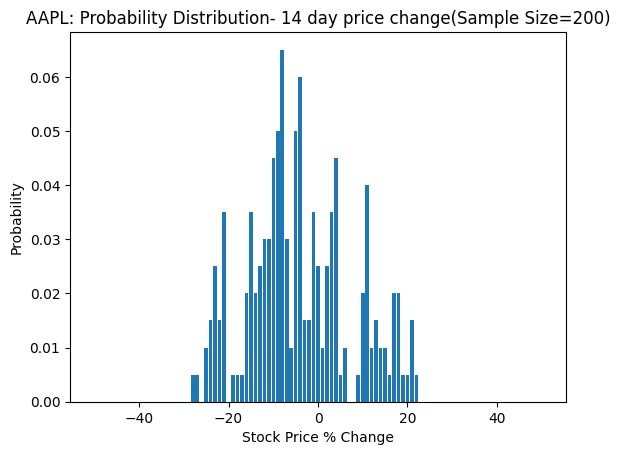

In [17]:
#SAMPLE SIZE 200
changes = delta_dist(ticker, 14, 200)
binned_changes = binned(changes)
x_axis = np.arange(-50, 51, 1)

plt.bar(x_axis, binned_changes)
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title('AAPL: Probability Distribution- 14 day price change(Sample Size=200)');


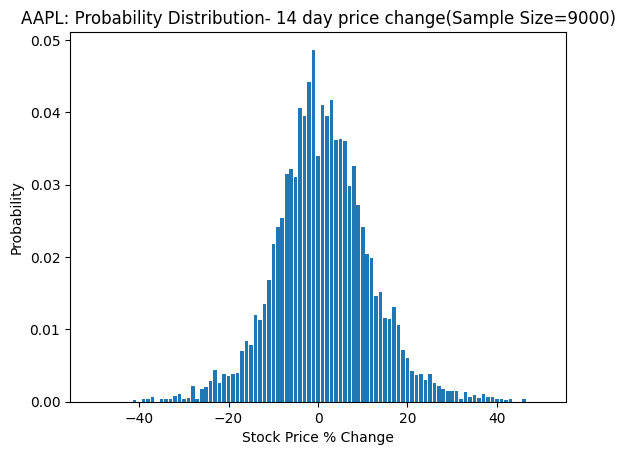

In [18]:
#SAMPLE SIZE 9000
changes = delta_dist('AAPL', 14, 9000)
binned_changes = binned(changes)
x_axis = np.arange(-50, 51, 1)

plt.bar(x_axis, binned_changes)
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title('AAPL: Probability Distribution- 14 day price change(Sample Size=9000)');



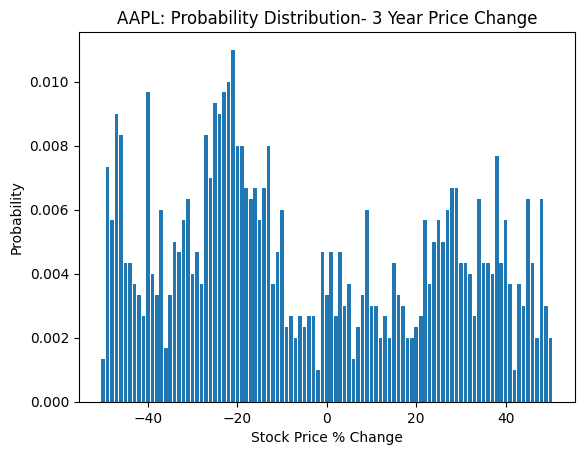

In [19]:
#SAMPLE SIZE 3000, DURATION = 5 years
changes = delta_dist('AAPL', 365*3, 3000)
binned_changes = binned(changes)
x_axis = np.arange(-50, 51, 1)

plt.bar(x_axis, binned_changes)
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title('AAPL: Probability Distribution- 3 Year Price Change');


In [20]:
#Generate time lapse between today and expiration of options contract:
timedate_until_exp = datetime.strptime(expiration, '%B %d, %Y') - datetime.today()
time_until_exp = int(timedate_until_exp.days)  #gives integer value of distance from today until expiration

In [21]:
#Creating dictionary containing each ticker and prob distribution 
scenario_tickers = list(set(options_df.Ticker))
number_of_tickers = len(scenario_tickers)
simulations = 2000

#dict_of_stuff will contain each ticker key corresponding to the 101 values of its distribution of price changes [-50%, 50%]
dict_of_probs = dict()
for stock in scenario_tickers:      #N is the sample size
    changes = delta_dist(stock, time_until_exp, simulations) 
    distribution_list = binned(changes)   #then, bin these changes so that they fit into the -50% to +50% integer counts
    dict_of_probs.update({stock : distribution_list})  #matches each ticker in dictionary with 101 counts 

Text(0.5, 1.0, '13 day average % price change for AMZN')

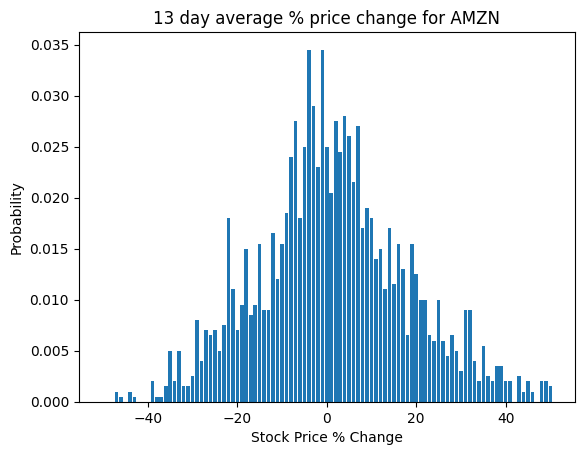

In [22]:
#Verify it works with example
x_axis = np.arange(-50, 51, 1)
example = random.randint(0, number_of_tickers - 1)

plt.bar(x_axis, dict_of_probs[scenario_tickers[example]])
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title(str(time_until_exp) + " day average % price change for " + str(scenario_tickers[example]))


In [23]:
#Generating expected payoffs
x_axis = np.arange(-50, 51, 1)
ExpectedPay = []

for i in range(len(options_df)):
    payoffs = []
    ticker = options_df.iloc[i].Ticker
    for p in range(len(x_axis)):
        percent = (p - 50)*0.01
        payoff = price_percent_payoff(percent, options_df.iloc[i])
        payoffs.append(payoff)
    #payoffs list contains the 101 values to be multiplied by the probabilities 
    probs = dict_of_probs[ticker]
    expected_value = sum( np.array(probs) * np.array(payoffs) )
    ExpectedPay.append(expected_value)

options_df['ExpectedPay'] = ExpectedPay

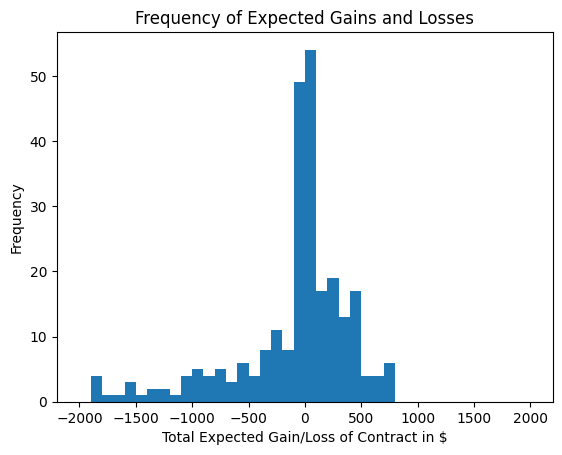

In [24]:
plt.hist(ExpectedPay, bins = 40, range=[-2000, 2000])
plt.xlabel('Total Expected Gain/Loss of Contract in $')
plt.ylabel('Frequency')
plt.title("Frequency of Expected Gains and Losses");
plt.savefig('payoffs.png', dpi = 800)